# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal, stats, special
from cycler import cycler
from scipy.optimize import curve_fit
from inspect import signature
from ipy_table import *

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

# Data structure

In [76]:
simulations = [
    {'label' : r'$k_f$=6, Sc=64', 'i' : 1, 'Sc': 64.0, 'kf' : 6.0, 'Rl' : 8, 'N': 128, 'Urms' : 0.25E-03, 'L' : 1.05, 'folder' : 'IRENE/R8/keta12/', 'runs' : [7], 'spec_ite' : 55000, 'lmbda' : 0.7832065E-01, 'eps' : 0.5145107E-04, 'eta' : 0.1180732E-01, 'chi' : 0.770757E+00},
    {'label' : r'$k_f$=12, Sc=1', 'i' : 1, 'Sc': 1.0, 'kf' : 12.0, 'Rl' : 8, 'N': 128, 'Urms' : 0.52010605E-03, 'L' : 0.51, 'folder' : 'IRENE/R8/keta6/3scalars/', 'runs' : [11], 'spec_ite' : 40000, 'h5_ite' : 100000},
    {'label' : r'$k_f$=12, Sc=64', 'i' : 2, 'Sc': 64.0, 'kf' : 12.0, 'Rl' : 8, 'N': 128, 'Urms' : 0.52010605E-03, 'L' : 0.51, 'folder' : 'IRENE/R8/keta6/3scalars/', 'runs' : [11], 'spec_ite' : 40000, 'h5_ite' : 100000},
    {'label' : r'$k_f$=12, Sc=256', 'i' : 3, 'Sc': 256.0, 'kf' : 12.0, 'Rl' : 8, 'N': 128, 'Urms' : 0.52010605E-03, 'L' : 0.51, 'folder' : 'IRENE/R8/keta6/3scalars/', 'runs' : [11], 'spec_ite' : 40000, 'h5_ite' : 100000},
    {'label' : r'$k_f$=25, Sc=1', 'i' : 1, 'Sc': 1.0, 'kf' : 25.0, 'Rl' : 8, 'N': 128, 'Urms' : 0.10510094E-02, 'L' : 0.25, 'folder' : 'IRENE/R8/keta3/3scalars/', 'runs' : [23], 'spec_ite' : 45000, 'h5_ite' : 100000},
    {'label' : r'$k_f$=25, Sc=16', 'i' : 2, 'Sc': 16.0, 'kf' : 25.0, 'Rl' : 8, 'N': 128, 'Urms' : 0.10510094E-02, 'L' : 0.25, 'folder' : 'IRENE/R8/keta3/3scalars/', 'runs' : [23], 'spec_ite' : 45000, 'h5_ite' : 100000},
    {'label' : r'$k_f$=25, Sc=64', 'i' : 3, 'Sc': 64.0, 'kf' : 25.0, 'Rl' : 8, 'N': 128, 'Urms' : 0.10510094E-02, 'L' : 0.25, 'folder' : 'IRENE/R8/keta3/3scalars/', 'runs' : [23], 'spec_ite' : 45000, 'h5_ite' : 100000},
]

In [77]:
viscosity = 0.0001

In [78]:
for simu in simulations :
    simu.update({'diffusivity': viscosity/simu['Sc'], 
                 'Pe_l' : simu["Sc"]*simu['Rl'],
                 'eta_b' : ((viscosity/simu['Sc'])**2*viscosity/simu['eps'])**(0.25)})

In [79]:
# lists
temp = []
dictList = [[key for key, value in simulations[0].items()]]
header = []

# convert the dictionary to a list
for dictionary in simulations :
    for key, value in dictionary.items():
        temp.append(value)
    dictList.append(temp)
    temp = []

make_table(dictList)
render()

label,i,Sc,kf,Rl,N,Urms,L,folder,runs,spec_ite,lmbda,eps,eta,chi,diffusivity,Pe_l,eta_b
"$R_\lambda$=20, $k_f$ = 24, $Sc$=36",1,36.0000,24.0000,20,1024,0.0140,0.2700,IRENE/Re20/Sc36/,"[1, 1, 4, 5, 6, 4]",5000,0.0783,0.0001,0.0118,0.7708,0.0000,720.0000,0.0020
"$R_\lambda$=20, $k_f$ = 24, $Sc$=64",1,64.0000,24.0000,20,2048,0.0140,0.2700,IRENE/Re20/Sc64/,"[1, 0, 1, 1, 0, 1, 1, 0, 1]",6000,0.0783,0.0001,0.0118,0.6439,0.0000,1280.0000,0.0015
"$R_\lambda$=40, $k_f$=9, $Sc$=1",1,1.0000,9.0000,40,256,0.0340,0.6000,IRENE/Re40/N256/Sc1/scalar_forcing2/,[44],90000,0.1255,0.0001,0.0098,0.0514,0.0001,40.0000,0.0098
"$R_\lambda$=40, $k_f$=9, $Sc$=16",1,16.0000,9.0000,40,1024,0.0340,0.6000,IRENE/Re40/N256/Sc16/,"[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]",6000,0.1424,0.0000,0.0120,0.0739,0.0000,640.0000,0.0030
"$R_\lambda$=40, $k_f$=17, $Sc$=4",1,4.0000,17.0000,40,1024,0.0680,0.3000,IRENE/Re40/N512/Sc4/,"[1, 1, 1, 1, 1, 1, 1]",6000,0.0638,0.0017,0.0049,0.0670,0.0000,160.0000,0.0025
"$R_\lambda$=40, $k_f$=35, $Sc$=1",1,1.0000,35.0000,40,1024,0.1050,0.1500,IRENE/Re40/N1024/Sc1/,[4],21000,0.0354,0.0133,0.0029,0.2585,0.0001,40.0000,0.0029
"$R_\lambda$=40, $k_f$=35, $Sc$=4",1,4.0000,35.0000,40,2048,0.1050,0.1500,IRENE/Re40/N1024/Sc4/,"[2, 1, 1, 2, 2, 1]",21000,0.0354,0.0133,0.0029,0.4096,0.0000,160.0000,0.0015
"$R_\lambda$=60, $k_f$ = 19, $Sc$=1",1,1.0000,19.0000,60,1024,0.1300,0.2600,IRENE/Re60/N1024/Sc1/,[3],12000,0.0456,0.0130,0.0030,0.9860,0.0001,60.0000,0.0030
"$R_\lambda$=60, $k_f$ = 19, $Sc$=4",1,4.0000,19.0000,60,2048,0.1300,0.2600,IRENE/Re60/N1024/Sc4/,"[1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1]",12000,0.0456,0.0130,0.0030,0.8034,0.0000,240.0000,0.0015
"$R_\lambda$=60, $k_f$ = 3, $Sc$=0.7",1,0.7000,3.0000,60,128,0.0150,2.2000,scalar/N128/Rl60_Sc07/,[795],12000,0.3714,0.0000,0.0252,0.6534,0.0001,42.0000,0.0301


In [80]:
for simu in simulations :
    print(1./simu['eta'], 1./simu['eta_b'], simu['N']/2)

84.69322420329084 508.1592707090613 512.0
84.69322420329084 677.5456942787484 1024.0
101.9698432346221 101.96985211059064 128.0
83.65827602044274 334.6332206907288 512.0
202.8153611543277 405.6306759196819 512.0
339.4915977527014 339.49159691950075 512.0
339.4915977527014 678.9831938390015 1024.0
337.83213121399973 337.8321170285892 512.0
337.83213121399973 675.6642340571784 1024.0
39.66838814248409 33.18895729068531 64.0


# Reading data

In [81]:
#read correlation files
def read_data_file(common_folder, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    for run_index in list(range(nb_of_runs)) :
        folder = common_folder + "run" + "%01d" % (run_index+1) + "/"
        if (run_files[run_index] < 1000) :
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
        else : 
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                try:
                    temp_array_line=list(map(float, line.split( )))
                    temp_array_line = [t * averaging_weight for t in temp_array_line]
                    file_data.append(temp_array_line)  
                except :
                    print('non fload in file' + file)
        if (run_index == 0) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    k = np.array(accumulated_data[0])
    nb_of_modes = np.array(accumulated_data[1])
    average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
    for i in list(range(average_data.shape[0])) : 
        average_data[i, :] = np.array(accumulated_data[i+2])
    t = average_data[:,0]
    numpy_file_table = np.array(average_data[:,1:])
    return [k, nb_of_modes, t, numpy_file_table]

In [82]:
# read velocity spectrum file
def read_spec_file(common_folder, forlder_in, quantity, spec_type, ite) :
    file = common_folder + forlder_in + quantity + "_" + spec_type + "_ite=%06d" % ite + ".table"
    print('reading file: ' + file)
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            try:
                temp_array_line=list(map(float, line.split( )))
            except :
                print('non float in ' + file)
            file_data.append(temp_array_line)  
    spec_table = np.array(file_data)
    k = spec_table[:,0]
    nb_of_modes = spec_table[:,1]
    Ek = spec_table[:,2]
#     Exx = spec_table[:,3]
#     Eyy = spec_table[:,4]
#     Ezz = spec_table[:,5]
    #return [k, nb_of_modes, Ek, Exx, Eyy, Ezz, spec_table[:,6], spec_table[:,7], spec_table[:,8], spec_table[:,9]]
    return [k, nb_of_modes, Ek]

In [83]:
common_folder = "/home/gorbunov8a/data/"
spec_type = "lin"
spec_component = "avg"
file_type = "two_point_corr_complex"

In [84]:
# read data files
for i,simu in enumerate(simulations) :
    [k, nb_of_modes, t, scalar_two_point_corr] = read_data_file(common_folder + simu['folder'], "scalar%01d" % simu['i'] + "_two_point_corr_complex", "lin", "avg", simu['runs'])
    simu.update({'k' : k, 'nb_of_modes': nb_of_modes, 'scalar_corr': scalar_two_point_corr, 'scalar_t' : t})
    #simu.update({'k' : k})
    simu['k'] = np.arange(1,simu['N']//2+1)
    #[k, nb_of_modes, t, scalar_two_point_corr] = read_data_file(common_folder + simu['folder'], "scalar1_two_point_corr_sqr", "lin", "avg", simu['runs'])
    #simu.update({'scalar_sqr_corr': scalar_two_point_corr})
    #[k, nb_of_modes, t, scalar_two_point_corr] = read_data_file(common_folder + simu['folder'], "scalar1_avg_real", "lin", "avg", simu['runs'])
    #simu.update({'scalar_avg': scalar_two_point_corr})   
    #[k, nb_of_modes, t, scalar_two_point_corr] = read_data_file(common_folder + simu['folder'], "scalar1_sqr_avg", "lin", "avg", simu['runs'])
    #simu.update({'scalar_sqr_avg': scalar_two_point_corr})   
#     [k, nb_of_modes, S2] = read_spec_file(common_folder+ simu['folder'], "run1/", "spectrum_scalar%01d" % simu['i'], "lin", simu['spec_ite'])
#     simu.update({'scal_spec': S2})
    
    #[k, nb_of_modes, t, vel_two_point_corr] = read_data_file(common_folder + simu['folder'], "two_point_corr_complex_real", "lin", "avg", simu['runs'])
    #simu.update({'vel_corr': vel_two_point_corr, 'vel_t' : t})
    #[k, nb_of_modes, t, vel_two_point_corr] = read_data_file(common_folder + simu['folder'], "two_point_corr_norms", "lin", "avg", simu['runs'])
    #simu.update({'vel_corr_norms': vel_two_point_corr})
    #[k, nb_of_modes, t, vel_two_point_corr] = read_data_file(common_folder + simu['folder'], "two_point_corr_sqrs", "lin", "avg", simu['runs'])
    #simu.update({'vel_corr_sqr': vel_two_point_corr})
    #[k, nb_of_modes, t, vel_two_point_corr] = read_data_file(common_folder + simu['folder'], "avg_complex_real", "lin", "avg", simu['runs'])
    #simu.update({'vel_avg': vel_two_point_corr})
    #[k, nb_of_modes, t, vel_two_point_corr] = read_data_file(common_folder + simu['folder'], "avg_norms", "lin", "avg", simu['runs'])
    #simu.update({'vel_avg_norms': vel_two_point_corr})
    #[k, nb_of_modes, t, vel_two_point_corr] = read_data_file(common_folder + simu['folder'], "avg_sqrs", "lin", "avg", simu['runs'])
    #simu.update({'vel_avg_sqr': vel_two_point_corr})
#     [k, nb_of_modes, Ek] = read_spec_file(common_folder + simu['folder'], "run1/", "vel_spec", "lin", simu['spec_ite'])
#     simu.update({'vel_spec': Ek, 'k_vel' : k, 'nb_of_modes_vel' : nb_of_modes})

reading file: /home/gorbunov8a/data/IRENE/Re20/Sc36/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=001.table
reading file: /home/gorbunov8a/data/IRENE/Re20/Sc36/run2/scalar1_two_point_corr_complex_lin_Cavg_wi=001.table
reading file: /home/gorbunov8a/data/IRENE/Re20/Sc36/run3/scalar1_two_point_corr_complex_lin_Cavg_wi=004.table
reading file: /home/gorbunov8a/data/IRENE/Re20/Sc36/run4/scalar1_two_point_corr_complex_lin_Cavg_wi=005.table
reading file: /home/gorbunov8a/data/IRENE/Re20/Sc36/run5/scalar1_two_point_corr_complex_lin_Cavg_wi=006.table
reading file: /home/gorbunov8a/data/IRENE/Re20/Sc36/run6/scalar1_two_point_corr_complex_lin_Cavg_wi=004.table
reading file: /home/gorbunov8a/data/IRENE/Re20/Sc64/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=001.table
reading file: /home/gorbunov8a/data/IRENE/Re20/Sc64/run2/scalar1_two_point_corr_complex_lin_Cavg_wi=000.table
reading file: /home/gorbunov8a/data/IRENE/Re20/Sc64/run3/scalar1_two_point_corr_complex_lin_Cavg_wi=001.table
reading fi

# Parameters

In [85]:
# Plotting options
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=14)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

In [86]:
kmin = 4
nb_of_curves = 9

for simu in simulations :
    simu['indices_before_forc'] = np.linspace(kmin,simu['kf'],nb_of_curves, dtype=int)
    simu['indices_after_forc'] = np.linspace(simu['kf'],100,nb_of_curves, dtype=int)
    #simu['indices_vel'] = np.linspace(5,np.max(simu['k_vel'])-5,nb_of_curves, dtype=int)

In [87]:
for simu in simulations :
    simu['t0'] = simu['L']/simu['Urms']

# Spectra

In [88]:
# fig, ax = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10,3.5))

# for i,simu in enumerate(simulations) :
#     xscaling = (simu['L'])**0
#     xscaling = 1.0
#     ax[0].plot(simu['k_vel']*xscaling, simu['vel_spec']*4.0*np.pi*(simu['k_vel']**2)/simu['nb_of_modes_vel'], '--', lw=1.0, markersize=5.5, color=colors[i], label='Velocity')
#     ax[0].plot(simu['k']*xscaling, simu['scal_spec']*4.0*np.pi*(simu['k']**2)/simu['nb_of_modes'], '-', lw=1.0, markersize=5.5, color=colors[i], label='Scalar %2.0f' % i)
    
#     #ax[1].plot(simu['k_vel']*xscaling, simu['vel_spec']*4.0*np.pi*(simu['k_vel']**2)/simu['nb_of_modes_vel']*(simu['k_vel']**(1.0)), '-', lw=1.0, markersize=5.5, color=colors[i], label='Velocity ' + simu['label'])
#     ax[1].plot(simu['k']*xscaling, simu['scal_spec']*4.0*np.pi*(simu['k']**2)/simu['nb_of_modes']*(simu['k']**(1.0)), '-', lw=1.0, markersize=5.5, color=colors[i], label='Scalar ' + simu['label'])
#     ax[0].axvline(x=simu['kf'], color=colors[i])
# #ax[0].plot(simu['k'], 1e-2*simu['k']**(-5.0/3.0), 'k--', label=r'$k^{-5/3}$', color='silver')
# ax[0].set(xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$E(k)$', title=r'Spectra'); ax[0].grid()
# ax[1].set(xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$E(k)k^{1}$', title=r'Spectra compensated by $k^{-1}$'); ax[1].grid()
# lgd = ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, ncol=1)
# # pp = PdfPages('../Images/IRENE/spectra_Re8_Sc64_diff_forc.pdf')
# # pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# # pp.close()

# plt.show()

Spectra from 2-p corr functions :

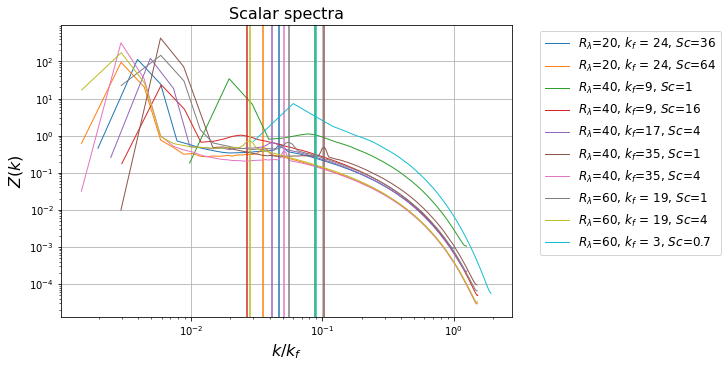

In [89]:
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(10,5))

for i,simu in enumerate(simulations) :
    xscaling = 1.0/simu['kf']
    xscaling = simu['eta_b']
    yscaling = (simu['chi']*(viscosity/simu['eps'])**0.5)**(-1)
    ax.plot(simu['k']*xscaling, simu['scalar_corr'][0,:]*4.0*np.pi*simu['k']**2*yscaling, '-', lw=1.0, markersize=5.5, color=colors[i], label=simu['label'])
    ax.axvline(x=simu['kf']*xscaling, color=colors[i])
#ax[0].plot(simu['k'], 1e-2*simu['k']**(-5.0/3.0), 'k--', label=r'$k^{-5/3}$', color='silver')
ax.set(xscale='log', yscale='log', xlabel=r'$k/k_f$', ylabel=r'$Z(k)$', title=r'Scalar spectra'); ax.grid()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, ncol=1)
# pp = PdfPages('../Images/IRENE/spectra_Re8_Sc64_diff_forc.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

plt.show()

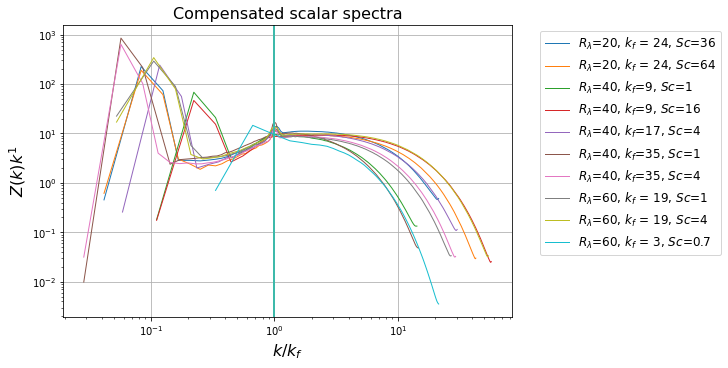

In [92]:
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(10,5))

for i,simu in enumerate(simulations) :
    xscaling = 1.0/simu['kf']
    #xscaling = simu['eta_b']
    yscaling = (simu['chi']*(viscosity/simu['eps'])**0.5)**(-1)
    ax.plot(simu['k']*xscaling, simu['scalar_corr'][0,:]*4.0*np.pi*simu['k']**(2+1)*yscaling, '-', lw=1.0, markersize=5.5, color=colors[i], label=simu['label'])
    ax.axvline(x=simu['kf']*xscaling, color=colors[i])
#ax[0].plot(simu['k'], 1e-2*simu['k']**(-5.0/3.0), 'k--', label=r'$k^{-5/3}$', color='silver')
ax.set(xscale='log', yscale='log', xlabel=r'$k/k_f$', ylabel=r'$Z(k)k^1$', title=r'Compensated scalar spectra'); ax.grid()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, ncol=1)
# pp = PdfPages('../Images/IRENE/spectra_Re8_Sc64_diff_forc.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

plt.show()

In [73]:
# fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(10,5))

# for i,simu in enumerate(simulations) :
#     x = 100*np.log(simu['k']/simu['kf'])/np.log(1./simu['eta_b']/simu['kf'])
#     yscaling = (simu['chi']*(viscosity/simu['eps'])**0.5)**(-1)
#     ax.plot(x, simu['scalar_corr'][0,:]*4.0*np.pi*simu['k']**(2+1)*yscaling, '-', lw=1.0, markersize=5.5, color=colors[i], label=simu['label'])
#     ax.axvline(x=x[int(simu['kf'])], color=colors[i])
# #ax[0].plot(simu['k'], 1e-2*simu['k']**(-5.0/3.0), 'k--', label=r'$k^{-5/3}$', color='silver')
# ax.set(xscale='linear', yscale='log', xlabel=r'$k/k_f$', ylabel=r'$Z(k)k^1$', title=r'Compensated scalar spectra'); ax.grid()
# lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, ncol=1)
# # pp = PdfPages('../Images/IRENE/spectra_Re8_Sc64_diff_forc.pdf')
# # pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# # pp.close()

# plt.show()

In [68]:
int(simu['kf'])

19

# 2-point time correlations

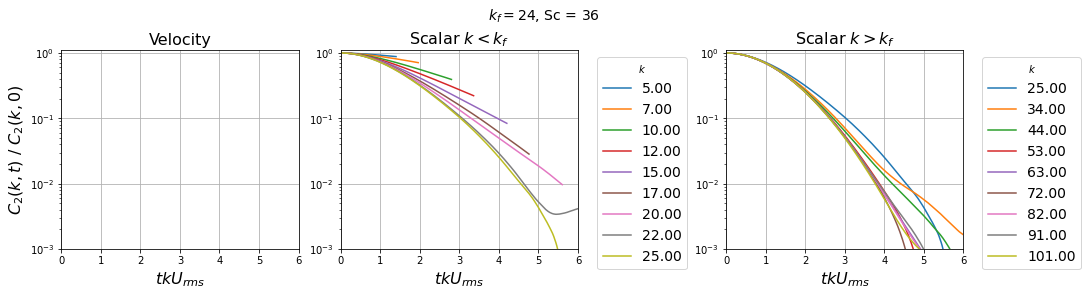

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(15,4.0))
simu = simulations[0]
title=fig.suptitle(r'$k_f = %2.0f$, Sc = %2.0f' % (simu['kf'], simu['Sc']), fontsize=14)
for ik in simu['indices_before_forc'] :
#for ik in [6,7,8,9] :
    scaling = (simu['k'][ik]*simu['Urms'])
    ax[1].plot(simu['scalar_t'][1:]*scaling, simu['scalar_corr'][1:,ik]/simu['scalar_corr'][1,ik], '-', label=r'%2.2f' % (simu['k'][ik]))
ax[0].set(xscale='linear',yscale='log', xlabel=r'$t k U_{rms}$', ylabel=r'$C_2(k,t) \ / \ C_2(k,0)$', title=r'Velocity'); ax[0].grid()
ax[1].set(xscale='linear',yscale='log', xlabel=r'$t k U_{rms}$', title=r'Scalar $k<k_f$'); ax[1].grid()
leg1 = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$')

for ik in simu['indices_after_forc'] :
    scaling = (simu['k'][ik]*simu['Urms'])**1
    #scaling = 1./simu['t0']
    ax[2].plot(simu['scalar_t'][1:]*scaling, simu['scalar_corr'][1:,ik]/simu['scalar_corr'][1,ik], '-', label=r'%2.2f' % (simu['k'][ik]))
ax[2].set(xscale='linear',yscale='log', xlabel=r'$t k U_{rms}$', title=r'Scalar $k>k_f$'); ax[2].grid()
leg2 = ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$')

x_max = 6.0
ymin = 1e-3
for axis in ax :
    axis.set(xlim=[0,x_max], ylim=[ymin,1.1])

# pp = PdfPages('../Images/IRENE/2pcorr_kf6_Re8_Sc64_diff_forc.pdf')
# pp.savefig(bbox_extra_artists=(title,leg1,leg2,), bbox_inches='tight')
# pp.close()
plt.show()

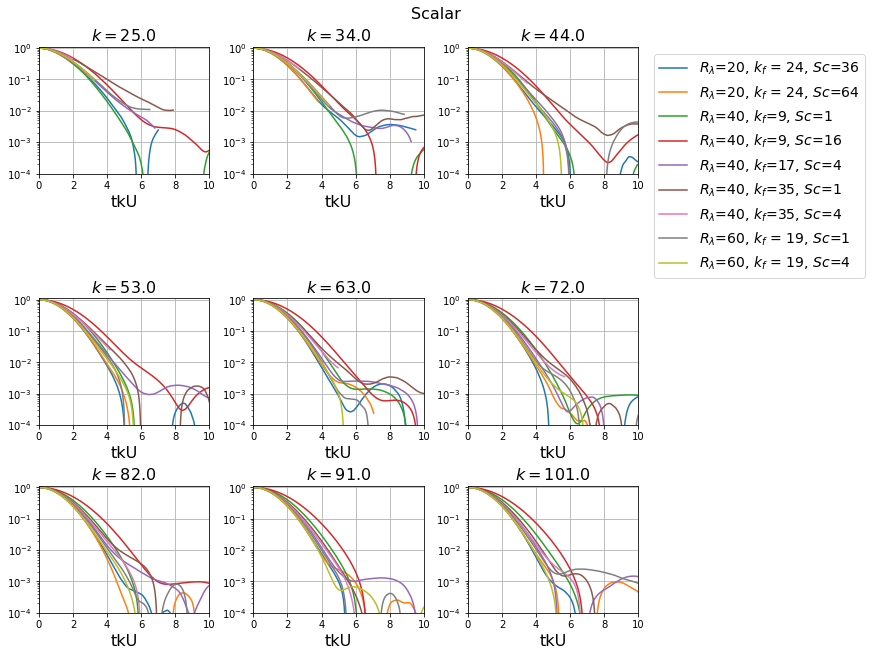

In [19]:
nb_of_rows = 3
nb_of_columns = 3
table = simulations[0]['indices_after_forc'].reshape(nb_of_rows,nb_of_columns)

fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_columns, figsize=(nb_of_columns*3+3,nb_of_rows*3), squeeze=False, constrained_layout=True)
fig.suptitle('Scalar', fontsize=16)
for index_plot, ik in np.ndenumerate(table):
    for index_simu, simu in enumerate(simulations[::]) :
        scaling = simu['k'][ik]*simu['Urms']
        ax[index_plot].plot(simu['scalar_t']*scaling, simu['scalar_corr'][:,ik]/simu['scalar_corr'][1,ik], '-', label=simu['label'], color=colors[index_simu])
        #ax[index_plot].plot(simu['scalar_t']*scaling, simu['scalar_avg'][:,ik], ':', label=simu['folder'], color=colors[index_simu])
        #ax[index_plot].plot(simu['scalar_t']*scaling, (simu['scalar_sqr_corr'][:,ik]-simu['scalar_sqr_avg'][:,ik]*simu['scalar_sqr_avg'][0,ik])/(simu['scalar_sqr_corr'][0,ik]-simu['scalar_sqr_avg'][0,ik]*simu['scalar_sqr_avg'][0,ik]), '--', label=simu['folder'], color=colors[index_simu])
    ax[index_plot].set(xscale='linear', yscale='log', xlabel='tkU', title=r'$k=%2.1f$' % simu['k'][ik])
    ax[index_plot].set(xlim=[0,10], ylim=[10e-5,1.1])
    ax[index_plot].grid()
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Correlation fit

In [20]:
def simple_gaussian(x, a, c):   
    return np.exp(-a*x**2.0 + c) 
def simple_gaussian_jacobian(x, a, c):   
    return np.transpose([-(x**2.0)*np.exp(-a * (x)**2.0 + c), np.exp(-a * (x)**2.0 + c)])

def exp_poly(x, a, b, c):   
    return np.exp(-a * (x)**2.0 + b*x + c) 
def exp_poly_jacobian(x, a, b, c):   
    return np.transpose([-(x**2.0)*np.exp(-a * (x)**2.0 +b*x + c), x*np.exp(-a * (x)**2.0 + b*x + c) ,np.exp(-a * (x)**2.0 + b*x + c)])

def simple_exp(x, a, c):   
    return np.exp(-a * x + c) 
def simple_exp_jacobian(x, a, c):   
    return np.transpose([-x*np.exp(-a * x + c), np.exp(-a * x + c)])

def linear_fun(x, a, b):   
    return (a * x + b) 
def linear_jacobian(x, a, b):   
    return np.transpose([x, np.ones_like(x)])

In [21]:
def try_to_fit(curve_function, xdata, ydata, sigma_ydata=None, jacobian_function=None) :
    number_of_params_of_optimization = len(signature(curve_function).parameters)-1
    coefficients = np.ndarray(shape=(number_of_params_of_optimization), dtype=float) 
    covariance_matrix = np.ndarray(shape=(number_of_params_of_optimization, number_of_params_of_optimization), dtype=float) 
    try :
        coefficients, covariance_matrix = curve_fit(curve_function, xdata, ydata, sigma=sigma_ydata, jac=jacobian_function, absolute_sigma=False)
    except :
        #print('[DEBUG] Failed optimization for ik = ', ik)
        coefficients.fill(np.nan); covariance_matrix.fill(np.nan)
    return [coefficients, covariance_matrix]

## Purely Gaussian fit

Pure Gaussian fit : Fitting the correlations function $f(x) = \exp\{-a x^2 + c \}$ 
with data $x = t/\tau_0$, $y = C^2(t,k)/C^2(t=0,k)$ :

In [22]:
tk_end_fit = 1.5
t_end_fit = 0.05
nb_of_params = 2
for simu in simulations :
    a = 1
    simu['gauss_fit_coef'] = np.full((len(simu['k']), nb_of_params), np.nan, dtype=float); simu['gauss_fit_coef_error'] = np.full((len(simu['k']), nb_of_params), np.nan, dtype=float)
    simu['gauss_chi2'] = np.full(len(simu['k']), np.nan, dtype=float)
    for ik, k in enumerate(simu['k']) :
        #b = np.searchsorted(simu['scalar_t']*k*simu['Urms'], tk_end_fit)
        b = np.searchsorted(simu['scalar_t']/simu['t0'], t_end_fit)
        if ((b-a) > 3) :
            xdata=simu['scalar_t'][a:b]/simu['t0']
            ydata=(simu['scalar_corr'][a:b,ik])/simu['scalar_corr'][0,ik]
            coef, covar = try_to_fit(simple_gaussian, xdata, ydata, jacobian_function=simple_gaussian_jacobian)
            simu['gauss_fit_coef'][ik] = coef
            simu['gauss_fit_coef_error'][ik] = np.sqrt(np.diagonal(covar))
            simu['gauss_chi2'][ik] = np.sum((ydata-simple_gaussian(xdata,*coef))**2)
    
#     simu['vel_gauss_fit_coef'] = np.full((len(simu['k_vel']), nb_of_params), np.nan, dtype=float); simu['vel_gauss_fit_coef_error'] = np.full((len(simu['k_vel']), nb_of_params), np.nan, dtype=float)
#     simu['vel_gauss_chi2'] = np.full(len(simu['k_vel']), np.nan, dtype=float)    
#     for ik, k in enumerate(simu['k_vel']) :
#         #b = np.searchsorted(simu['scalar_t']*k*simu['Urms'], tk_end_fit)
#         b = np.searchsorted(simu['scalar_t']/simu['t0'], t_end_fit)
#         if ((b-a) > 3) :
#             xdata=simu['vel_t'][a:b]/simu['t0']
#             ydata=(simu['vel_corr'][a:b,ik])/simu['vel_corr'][0,ik]
#             coef, covar = try_to_fit(simple_gaussian, xdata, ydata, jacobian_function=simple_gaussian_jacobian)
#             simu['vel_gauss_fit_coef'][ik] = coef
#             simu['vel_gauss_fit_coef_error'][ik] = np.sqrt(np.diagonal(covar))
#             simu['vel_gauss_chi2'][ik] = np.sum((ydata-simple_gaussian(xdata,*coef))**2)    

Plot results of fitting (purely gaussian) :

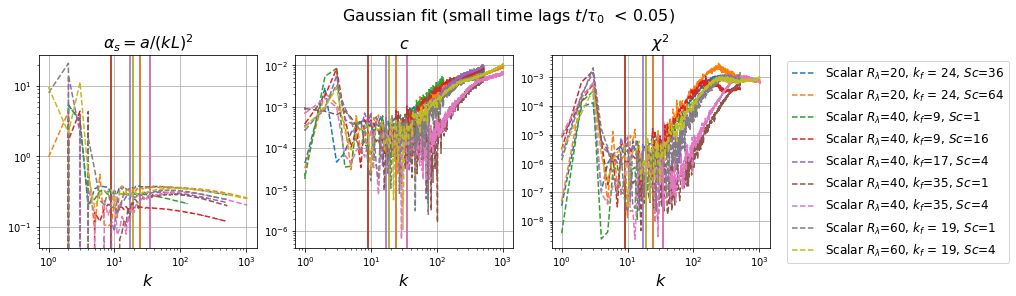

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(14,4))
fig.suptitle(r'Gaussian fit (small time lags $t/\tau_0$  < 0.05)', fontsize=16)
for i,simu in enumerate(simulations[::]) : 
    xscaling = 1.0
    ax[0].errorbar(simu['k']*xscaling, simu['gauss_fit_coef'][:,0]/(simu['k']*simu['L'])**2, yerr=simu['gauss_fit_coef_error'][:,0]/simu['k']**2, errorevery=5, ls='--', color=colors[i])
    ax[1].errorbar(simu['k']*xscaling, np.abs(simu['gauss_fit_coef'][:,1]), yerr=simu['gauss_fit_coef_error'][:,1], errorevery=5, ls='--', color=colors[i])
    ax[2].plot(simu['k']*xscaling, simu['gauss_chi2'], label='Scalar ' + simu['label'], ls='--', color=colors[i])
    
#     ax[0].errorbar(simu['k_vel']*xscaling, simu['vel_gauss_fit_coef'][:,0]/(simu['k_vel']*simu['L'])**2, yerr=simu['vel_gauss_fit_coef_error'][:,0]/simu['k_vel']**2, errorevery=5, ls='-', color=colors[i])
#     ax[1].errorbar(simu['k_vel']*xscaling, np.abs(simu['vel_gauss_fit_coef'][:,1]), yerr=simu['vel_gauss_fit_coef_error'][:,1], errorevery=5, ls='-', color=colors[i])
#     ax[2].plot(simu['k_vel']*xscaling, simu['vel_gauss_chi2'], label='Velocity ' + simu['label'], ls='-', color=colors[i])
    for axis in ax :
        axis.axvline(x=simu['kf'], color=colors[i])
ax[0].set(xlabel=r'$k$', title=r'$\alpha_s = a/(kL)^2$', xscale='log', yscale='log'); ax[0].grid()
ax[1].set(xlabel=r'$k$', title=r'$c$', yscale='log', xscale='log'); ax[1].grid()
ax[2].set(xlabel=r'$k$', title=r'$\chi^2$', yscale='log', xscale='log'); ax[2].grid()
#ax[0].set(ylim=[0,5])
lgd = ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, ncol=1)

# pp = PdfPages('../Images/IRENE/gausssian_fit_Re8_Sc64_diff_forc.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

plt.show()

### Compare Gaussian fit and data

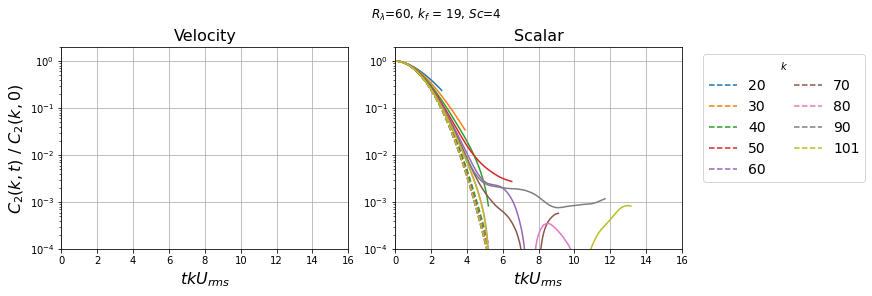

In [24]:
simu = simulations[-1]

fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(12,4))
fig.suptitle(simu['label'])

for i,ik in enumerate(simu['indices_after_forc']) :
    scaling = simu['k'][ik]*simu['Urms']
    #ax[0].plot(simu['vel_t']*scaling, simu['vel_corr'][:,ik]/simu['vel_corr'][0,ik], '-', color=colors[i])
    #ax[0].plot(simu['vel_t']*scaling, simple_gaussian(simu['vel_t']/simu['t0'],*simu['vel_gauss_fit_coef'][ik]), '--', color=colors[i])
    ax[1].plot(simu['scalar_t'][:]*scaling, simu['scalar_corr'][:,ik]/simu['scalar_corr'][0,ik], '-', color=colors[i])
    ax[1].plot(simu['scalar_t']*scaling, simple_gaussian(simu['scalar_t']/simu['t0'],*simu['gauss_fit_coef'][ik]), '--', label=r'%2.0f' % (simu['k'][ik]), color=colors[i])
ax[0].set(xscale='linear',yscale='log', xlabel=r'$t k U_{rms}$', ylabel=r'$C_2(k,t) \ / \ C_2(k,0)$', title=r'Velocity'); ax[0].grid()
ax[1].set(xscale='linear',yscale='log', xlabel=r'$t k U_{rms}$', title=r'Scalar'); ax[1].grid()

x_max = 16.0
ax[0].set(xlim=[0,x_max], ylim=[10e-5,2.0])
ax[1].set(xlim=[0,x_max], ylim=[10e-5,2.0])
lgd = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$', ncol=2)

#pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl70_Sc1.pdf')
#pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
#pp.close()
plt.show()

## Fitting correlations with exponential after Gaussian

Cut the oscillating tails :

In [25]:
threshold_sca = 10e-3
threshold_vel = 5e-2
for i,simu in enumerate(simulations) : 
    simu['sca_it_cut-off'] = np.zeros_like(simu['k'], dtype=int); #simu['vel_it_cut-off'] = np.zeros_like(simu['k_vel'], dtype=int)
    for ik, k in enumerate(simu['k']) :
        small_amplitudes = np.argwhere(simu['scalar_corr'][:,ik]/simu['scalar_corr'][0,ik]<threshold_sca)
        if (len(small_amplitudes) > 0) :
            simu['sca_it_cut-off'][ik] = small_amplitudes[0,0]
        else :
            simu['sca_it_cut-off'][ik] = len(simu['scalar_t']) - 1
            
#     for ik, k in enumerate(simu['k_vel']) :
#         small_amplitudes = np.argwhere(simu['vel_corr'][:,ik]/simu['vel_corr'][0,ik]<threshold_vel)
#         if (len(small_amplitudes) > 0) :
#             simu['vel_it_cut-off'][ik] = small_amplitudes[0,0]
#         else :
#             simu['vel_it_cut-off'][ik] = len(simu['vel_t']) - 1

Perform exponential fit :

In [26]:
crossover_time = 0.3

for i,simu in enumerate(simulations) : 
    simu['scalar_large_time_fit'] = np.full((len(simu['k']), 2), np.nan, dtype=float)
    #simu['vel_large_time_fit'] = np.full((len(simu['k_vel']), 2), np.nan, dtype=float)
    simu['crossover_time_index'] = np.searchsorted(simu['scalar_t']/simu['t0'], crossover_time)
    for ik, k in enumerate(simu['k']) :       
        if (simu['sca_it_cut-off'][ik]>simu['crossover_time_index']) :
            time_sl = np.s_[simu['crossover_time_index']:simu['sca_it_cut-off'][ik]]
            x = simu['scalar_t'][time_sl]/simu['t0']
            y = np.log(simu['scalar_corr'][time_sl,ik])
            if (len(y) > 10) :
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                simu['scalar_large_time_fit'][ik] = [slope, intercept]

#                 if (ik < len(simu['k_vel'])) :
#                     time_sl = np.s_[simu['crossover_time_index']:simu['sca_it_cut-off'][ik]]
#                     x = simu['scalar_t'][time_sl]/simu['t0']
#                     y = np.log(simu['vel_corr'][time_sl,ik])
#                     if (len(x) > 3) :
#                         slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#                         simu['vel_large_time_fit'][ik] = [slope, intercept]

### Velocity

In [27]:
# fig, ax = plt.subplots(nrows=1, ncols=len(simulations), constrained_layout=True,figsize=(4.0*len(simulations),4))
# title = fig.suptitle(r'$C^{(2)}(t,k)$ for velocity', fontsize=16)
# for isimu, simu in enumerate(simulations) :
#     for i,ik in enumerate(simu['indices_vel'][:]) :
#         xscaling = (simu['k'][ik]*simu['L'])**0
#         x = simu['vel_t']/simu['t0']*xscaling
#         time_sl = np.s_[simu['crossover_time_index']:simu['vel_it_cut-off'][ik]]
#         ax[isimu].plot(x, simu['vel_corr'][:,ik]/simu['vel_corr'][0,ik], '-',  color=colors[i], lw=1)
#         ax[isimu].plot(x[time_sl], simu['vel_corr'][time_sl,ik]/simu['vel_corr'][0,ik], '.-', color=colors[i], label=r'%2.0f' % (simu['k'][ik]))
#         ax[isimu].plot(x, np.exp(simu['vel_large_time_fit'][ik][0]*simu['vel_t']/simu['t0'] + simu['vel_large_time_fit'][ik][1])/simu['vel_corr'][0,ik], '--', color=colors[i])
#     ax[isimu].set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0 (kL)^2$', title=simu['label']); 
#     ax[isimu].grid()
# lgd = ax[isimu].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$')

# for axes in ax : 
#     axes.set(ylim=[1e-4,1.1])
# ax[0].set(xlim=[0,1.0])
# ax[1].set(xlim=[0,0.8])
# ax[2].set(xlim=[0,0.800])
# ax[3].set(xlim=[0,0.800])
# # pp = PdfPages('../Images/IRENE/velocity_large_Re8_Sc64_diff_forc.pdf')
# # pp.savefig(bbox_extra_artists=(title,lgd,), bbox_inches='tight')
# # pp.close()
# plt.show()

In [28]:
# fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,4))

# for i,simu in enumerate(simulations) : 
#     xscaling = 1.0
#     ax.plot(simu['k_vel']*xscaling, -simu['vel_large_time_fit'][:,0], '.-', color=colors[i], label=simu['label'])
#     ax.axvline(x=simu['kf'], color=colors[i])
# ax.plot(simu['k_vel']*xscaling, 1.0e-2*(simu['k_vel']*xscaling)**2, 'k--', label=r'$k^2$')
# ax.plot(simu['k_vel']*xscaling, 0.5e1*(simu['k_vel']*xscaling)**1, 'r--', label=r'$k^1$')
# ax.set(xlabel=r'$k$', title=r'$ b$', yscale='log', xscale='log'); ax.grid()
# # ax.set(ylim=[0,100])
# # ax.set(xlim=[0,50])
# lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# # pp = PdfPages('../Images/IRENE/velocity_large_fit_Re8_Sc64_diff_forc.pdf')
# # pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# # pp.close()
# plt.show()

In [29]:
# fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,4))
# sl = np.s_[2::]
# for i,simu in enumerate(simulations) : 
#     xscaling = 1.0
#     ax.plot(simu['k_vel'][sl]*xscaling, -simu['vel_large_time_fit'][sl,0]*(simu['k_vel'][sl]*simu['L'])**(-2), '.-', color=colors[i], label=simu['label'])
#     ax.axvline(x=simu['kf'], color=colors[i])
# ax.set(xlabel=r'$k$', title=r'$\alpha_L = b / (kL)^{2}$', yscale='linear', xscale='log'); ax.grid()
# # ax.set(ylim=[0,100])
# # ax.set(xlim=[0,50])
# lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# # pp = PdfPages('../Images/IRENE/velocity_compens_large_fit_Re8_Sc64_diff_forc.pdf')
# # pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# # pp.close()
# plt.show()

### Scalar

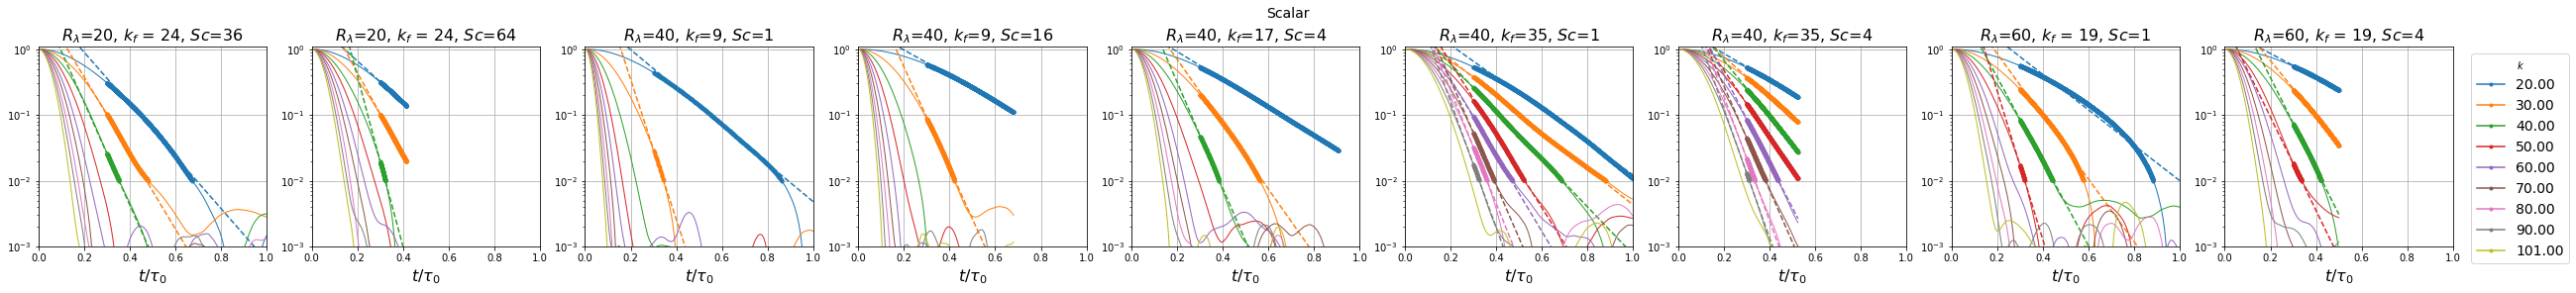

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=len(simulations), constrained_layout=True,figsize=(4.0*len(simulations),4))
fig.suptitle('Scalar', fontsize=14)
for isimu, simu in enumerate(simulations) :
    for i,ik in enumerate(simu['indices_after_forc'][:]) :
        x = simu['scalar_t']/simu['t0']
        time_sl = np.s_[simu['crossover_time_index']:simu['sca_it_cut-off'][ik]]
        ax[isimu].plot(x, simu['scalar_corr'][:,ik]/simu['scalar_corr'][0,ik], '-',  color=colors[i], lw=1)
        ax[isimu].plot(x[time_sl], simu['scalar_corr'][time_sl,ik]/simu['scalar_corr'][0,ik], '.-', color=colors[i], label=r'%2.2f' % (simu['k'][ik]))
        ax[isimu].plot(x, np.exp(simu['scalar_large_time_fit'][ik][0]*x + simu['scalar_large_time_fit'][ik][1])/simu['scalar_corr'][0,ik], '--', color=colors[i])
    ax[isimu].set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0$', title=simu['label']); 
    ax[isimu].grid()

x_max=1.0
for axes in ax :
    axes.set(xlim=[0,x_max])
    axes.set(ylim=[1e-3,1.1])

leg = ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$')

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

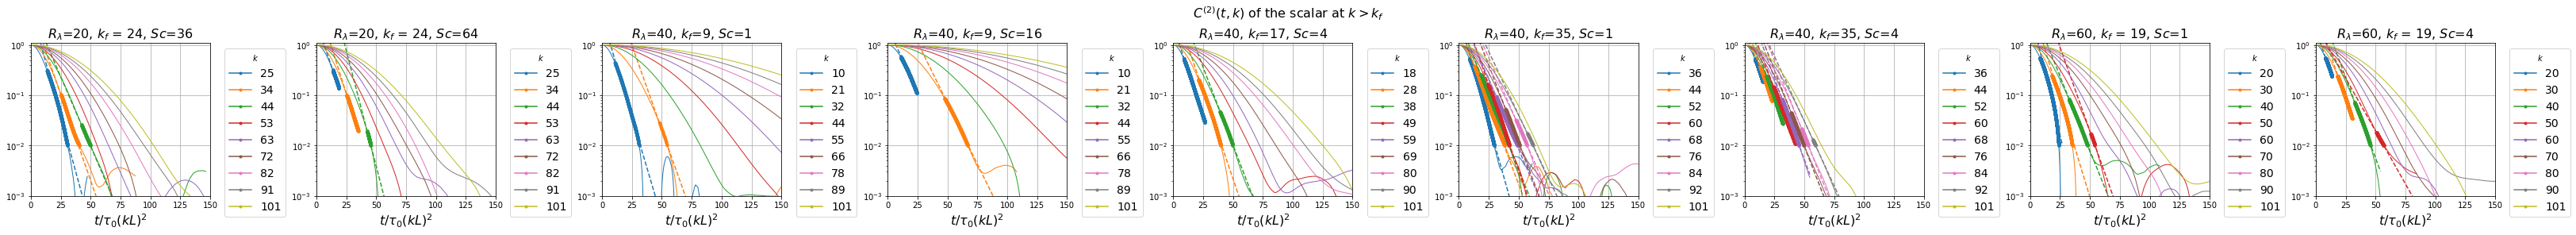

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=len(simulations), constrained_layout=True,figsize=(5*len(simulations),4))
title = fig.suptitle(r'$C^{(2)}(t,k)$ of the scalar at $k>k_f$', fontsize=16)
for isimu, simu in enumerate(simulations) :
    for i,ik in enumerate(simu['indices_after_forc'][:]) :
        x = simu['scalar_t']/simu['t0']
        xscaling = (simu['k'][ik]*simu['L'])**2
        time_sl = np.s_[simu['crossover_time_index']:simu['sca_it_cut-off'][ik]]
        ax[isimu].plot(x*xscaling, simu['scalar_corr'][:,ik]/simu['scalar_corr'][0,ik], '-',  color=colors[i], lw=1)
        ax[isimu].plot(x[time_sl]*xscaling, simu['scalar_corr'][time_sl,ik]/simu['scalar_corr'][0,ik], '.-', color=colors[i], label=r'%2.0f' % (simu['k'][ik]))
        ax[isimu].plot(x*xscaling, np.exp(simu['scalar_large_time_fit'][ik][0]*x + simu['scalar_large_time_fit'][ik][1])/simu['scalar_corr'][0,ik], '--', color=colors[i])
    ax[isimu].set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0 (kL)^2$', title=simu['label']); 
    ax[isimu].grid()
    lgd = ax[isimu].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$')

for axes in ax : 
    axes.set(ylim=[1e-3,1.1])
    axes.set(xlim=[0,150])
# ax[1].set(xlim=[0,150])
# ax[2].set(xlim=[0,100])
# ax[3].set(xlim=[0,100])
# pp = PdfPages('../Images/IRENE/scalar_large_corr_Re8_Sc64_diff_forc.pdf')
# pp.savefig(bbox_extra_artists=(title,lgd,), bbox_inches='tight')
# pp.close()
plt.show()

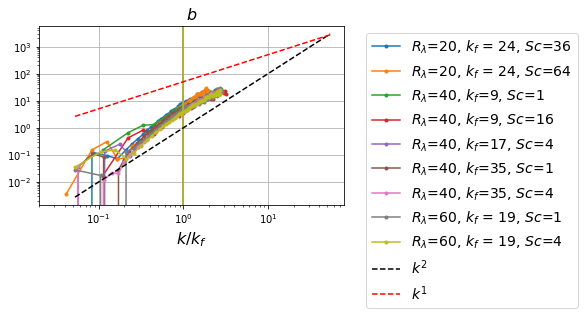

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(8,4))

for i,simu in enumerate(simulations) : 
    xscaling = 1./simu['kf']
    ax.plot(simu['k']*xscaling, -simu['scalar_large_time_fit'][:,0], '.-', color=colors[i], label=simu['label'])
    ax.axvline(x=simu['kf']*xscaling, color=colors[i])
ax.plot(simu['k']*xscaling, 1.0e-0*(simu['k']*xscaling)**2, 'k--', label=r'$k^2$')
ax.plot(simu['k']*xscaling, 0.5e2*(simu['k']*xscaling)**1, 'r--', label=r'$k^1$')
ax.set(xlabel=r'$k/k_f$', title=r'$ b$', yscale='log', xscale='log'); ax.grid()
# ax.set(ylim=[0,100])
# ax.set(xlim=[0,50])
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# pp = PdfPages('../Images/IRENE/scalar_large_fit_Re8_Sc64_diff_forc.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

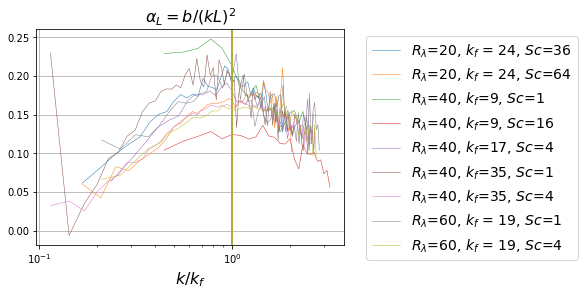

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(8,4))
sl = np.s_[3::]
for i,simu in enumerate(simulations[::]) : 
    xscaling = 1./simu['kf']
    #xscaling = simu['eta_b']
    ax.plot(simu['k'][sl]*xscaling, -simu['scalar_large_time_fit'][sl,0]*(simu['k'][sl]*simu['L'])**(-2.0), '-', color=colors[i], label=simu['label'], lw=0.5)
    ax.axvline(x=simu['kf']*xscaling, color=colors[i])
ax.set(xlabel=r'$k/k_f$', title=r'$\alpha_L = b / (kL)^{2}$', yscale='linear', xscale='log'); ax.grid()
# ax.set(ylim=[0,100])
# ax.set(xlim=[0,50])
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# pp = PdfPages('../Images/IRENE/scalar_compens_large_fit_Re8_Sc64_diff_forc.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

In [34]:
# fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,4))

# for i,simu in enumerate(simulations) : 
#     xscaling = 1.0
#     ax.plot(simu['k']*xscaling, -simu['scalar_large_time_fit'][:,0]*simu['t0']*(simu['k']*simu['L'])**(-1), '.-', color=colors[i], label=simu['label'])
#     ax.axvline(x=simu['kf'], color=colors[i])
# ax.set(xlabel=r'$k$', title=r'$b(kL)^{-1}$', yscale='log', xscale='log'); ax.grid()
# # ax.set(ylim=[0,100])
# # ax.set(xlim=[0,50])
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.show()

# Crossover

In [35]:
# compute time derivatives of the corr function
for simu in simulations : 
    simu['deriv1'] = np.ndarray(shape=(len(simu['k']), len(simu['scalar_t'])), dtype=float)
    simu['deriv2'] = np.ndarray(shape=(len(simu['k']), len(simu['scalar_t'])), dtype=float)
    #simu['deriv1_vel'] = np.ndarray(shape=(len(simu['k_vel']), len(simu['vel_t'])), dtype=float)
    for ik in range(len(simu['k'])) :
        sl = np.s_[0:len(simu['scalar_t'])]
        #data = np.cumsum(simu['scalar_corr'][:,ik]/simu['scalar_corr'][0,ik])
        simu['deriv1'][ik,:] = np.gradient(np.log(simu['scalar_corr'][:,ik]), simu['scalar_t'][sl]/simu['t0'], edge_order=1)
        #simu['deriv2'][ik,:] = np.gradient(simu['deriv1'][ik,:] / (simu['scalar_corr'][sl,ik] / simu['scalar_corr'][1,ik]), simu['scalar_t'][sl], edge_order=1)
        #simu['deriv1'][ik,:] = np.gradient(np.log(np.abs(simu['scalar_corr'][sl,ik] / simu['scalar_corr'][1,ik])), np.log(simu['scalar_t'][sl]), edge_order=1)
#     for ik in range(len(simu['k_vel'])) :
#         simu['deriv1_vel'][ik,:] = np.gradient(np.log(simu['vel_corr'][:,ik]), simu['vel_t'][sl]/simu['t0'], edge_order=1)
#         #simu['deriv1_vel'][ik,:] = np.gradient(np.cumsum(simu['scalar_corr'][sl,ik]/simu['scalar_corr'][0,ik]), simu['vel_t'][sl], edge_order=1)

/tmp/ipykernel_12064/2910862884.py:9: RuntimeWarning: invalid value encountered in log
  simu['deriv1'][ik,:] = np.gradient(np.log(simu['scalar_corr'][:,ik]), simu['scalar_t'][sl]/simu['t0'], edge_order=1)


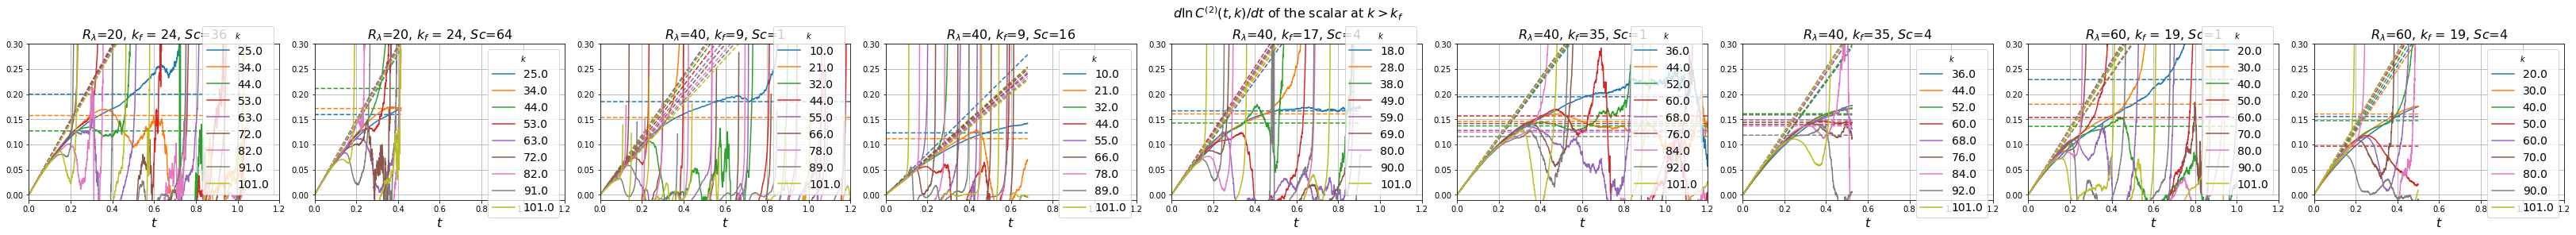

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=len(simulations), constrained_layout=True,figsize=(5*len(simulations),4))
title = fig.suptitle(r'$d \ln C^{(2)}(t,k)/ d t$ of the scalar at $k>k_f$', fontsize=16)
for isimu, simu in enumerate(simulations) :
    for iik,ik in enumerate(simu['indices_after_forc'][:]) :
        x = simu['scalar_t']/simu['t0']
        end_of_slice = np.where(simu['deriv1'][ik] > 0)
        # if len(end_of_slice[0]) > 0 :
        #     sl=np.s_[2:end_of_slice[0][0]:]
        # else :
        sl=np.s_[2:-1:]
        ax[isimu].plot(x[sl],-simu['deriv1'][ik][sl]/(simu['k'][ik]*simu['L'])**2,  '-', label='%2.1f' % (simu['k'][ik]))
        ax[isimu].plot(x, 2.0*simu['gauss_fit_coef'][ik,0]*x/(simu['k'][ik]*simu['L'])**2, '--', color=colors[iik])
        ax[isimu].plot(x, -np.full_like(x,simu['scalar_large_time_fit'][ik][0])/(simu['k'][ik]*simu['L'])**2, '--', color=colors[iik])
    ax[isimu].set(xlabel=r'$t$', yscale='linear', title=simu['label']); ax[isimu].grid()
    ax[isimu].set(ylim=(-0.01,0.3), xlim=[0,1.2])
    lgd2 = ax[isimu].legend(loc='best', ncol=1, title=r'$k$') 
#  for axes in ax : 
#     axes.set(ylim=[1e-3,1.1])
#     axes.set(xlim=[0,150])
# ax[1].set(xlim=[0,150])
# ax[2].set(xlim=[0,100])
# ax[3].set(xlim=[0,100])
# pp = PdfPages('../Images/IRENE/scalar_large_corr_Re8_Sc64_diff_forc.pdf')
# pp.savefig(bbox_extra_artists=(title,lgd,), bbox_inches='tight')
# pp.close()
plt.show()

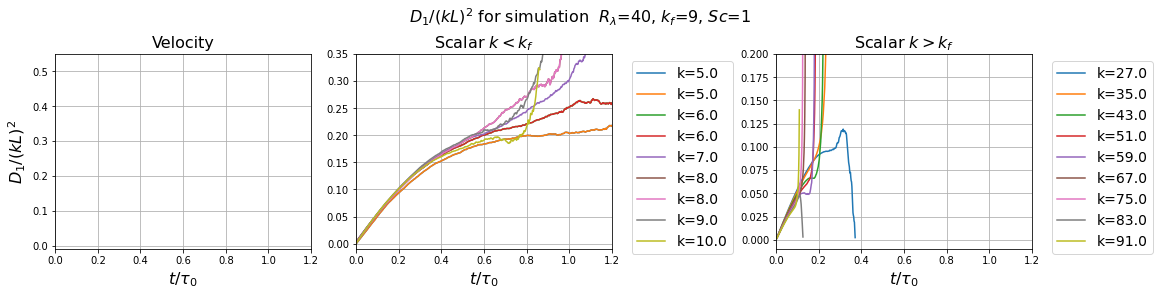

In [41]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4), constrained_layout=True)
# simu = simulations[2]
# title = fig.suptitle(r'$D_1/(kL)^2$ for simulation  ' + simu['label'], fontsize=16)
# sl=np.s_[1::]
# #for iik, ik in enumerate(np.linspace(5,simu['N']//2-5,20, dtype=int))  :
# #for ik in [6,7] :
# for iik,ik in enumerate(simu['indices_before_forc'][:]) :
#     x = simu['scalar_t']/simu['t0']
#     #end_of_slice = np.where(simu['deriv1'][ik] > 0)
# #     if len(end_of_slice[0]) > 0 :
# #         sl=np.s_[2:end_of_slice[0][0]:]
# #     else :
# #         sl=np.s_[2:-1:]
#     sl = np.s_[2:simu['sca_it_cut-off'][ik]:]
#     #ax[0].plot(x[sl],-simu['deriv1_vel'][ik][sl]/(simu['k_vel'][ik]*simu['L'])**2, '.', label='k=%2.1f' % (simu['k'][ik]), ms=2.0)
#     ax[1].plot(x[sl],-simu['deriv1'][ik][sl]/(simu['k'][ik]*simu['L'])**2,  '-', label='k=%2.1f' % (simu['k'][ik]))
#     #ax[1].plot(x, 2.0*simu['gauss_fit_coef'][ik,0]*x/(simu['k'][ik])**2, '--', color=colors[iik])
#     #ax[1].plot(x, -np.full_like(x,simu['scalar_large_time_fit'][ik][0])/(simu['k'][ik])**2, '--', color=colors[iik])
# ax[0].set(xlabel=r'$t/\tau_0$', ylabel=r'$D_1/(kL)^2$', title='Velocity', yscale='linear'); ax[0].grid()
# ax[1].set(xlabel=r'$t/\tau_0$', title=r'Scalar $k<k_f$', yscale='linear'); ax[1].grid()
# ax[0].set(ylim=(-0.01,0.55), xlim=[0,1.2])
# ax[1].set(ylim=(-0.01,0.35), xlim=[0,1.2])
# lgd1 = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

# #for iik,ik in enumerate(simu['indices_after_forc'][:]) :
# for iik,ik in enumerate(np.linspace(26,90,9, dtype=int)) :
#     x = simu['scalar_t']/simu['t0']
#     end_of_slice = np.where(simu['deriv1'][ik] > 0)
#     if len(end_of_slice[0]) > 0 :
#         sl=np.s_[2:end_of_slice[0][0]:]
#     else :
#         sl=np.s_[2:-1:]
#     ax[2].plot(x[sl],-simu['deriv1'][ik][sl]/(simu['k'][ik]*simu['L'])**2,  '-', label='k=%2.1f' % (simu['k'][ik]))
# #     ax[2].plot(x, 2.0*simu['gauss_fit_coef'][ik,0]*x/(simu['k'][ik]*simu['L'])**2, '--', color=colors[iik])
# #     ax[2].plot(x, -np.full_like(x,simu['scalar_large_time_fit'][ik][0])/(simu['k'][ik]*simu['L'])**2, '--', color=colors[iik])
# ax[2].set(xlabel=r'$t/\tau_0$', title=r'Scalar $k>k_f$', yscale='linear'); ax[2].grid()
# ax[2].set(ylim=(-0.01,0.2), xlim=[0,1.2])
# lgd2 = ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
# # pp = PdfPages('../Images/IRENE/crossover_d1_compens_large_fit_Re8_Sc64_diff_forc.pdf')
# # pp.savefig(bbox_extra_artists=(title,lgd1,lgd2,), bbox_inches='tight')
# # pp.close()
# plt.show()

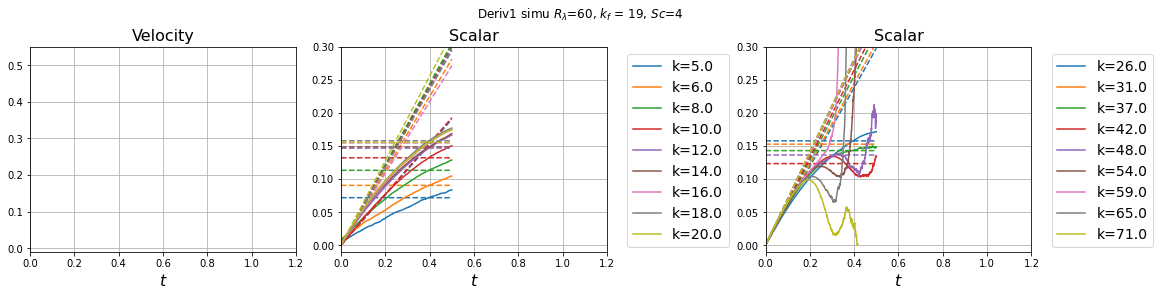

In [37]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4), constrained_layout=True)
# simu = simulations[-1]
# fig.suptitle('Deriv1 simu ' + simu['label'] )
# sl=np.s_[1::]
# #for iik, ik in enumerate(np.linspace(5,simu['N']//2-5,20, dtype=int))  :
# #for ik in [6,7] :
# for iik,ik in enumerate(simu['indices_before_forc'][:]) :
#     x = simu['scalar_t']/simu['t0']
# #     end_of_slice = np.where(simu['deriv1'][ik] > 0)
# #     if len(end_of_slice[0]) > 0 :
# #         sl=np.s_[2:end_of_slice[0][0]:]
# #     else :
# #         sl=np.s_[2:-1:]
#     sl = np.s_[2:simu['sca_it_cut-off'][ik]:]
#     #ax[0].plot(x[sl],-simu['deriv1_vel'][ik][sl]/(simu['k_vel'][ik]*simu['L'])**2, '.', label='k=%2.1f' % (simu['k'][ik]), ms=2)
#     ax[1].plot(x[sl],-simu['deriv1'][ik][sl]/(simu['k'][ik]*simu['L'])**2,  '-', label='k=%2.1f' % (simu['k'][ik]))
#     ax[1].plot(x, 2.0*simu['gauss_fit_coef'][ik,0]*x/(simu['k'][ik]*simu['L'])**2, '--', color=colors[iik])
#     ax[1].plot(x, -np.full_like(x,simu['scalar_large_time_fit'][ik][0])/(simu['k'][ik]*simu['L'])**2, '--', color=colors[iik])
# ax[0].set(xlabel=r'$t$', title='Velocity', yscale='linear'); ax[0].grid()
# ax[1].set(xlabel=r'$t$', title='Scalar', yscale='linear'); ax[1].grid()
# ax[0].set(ylim=(-0.01,0.55), xlim=[0,1.2])
# ax[1].set(ylim=(-0.01,0.3), xlim=[0,1.2])
# lgd = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

# #for iik,ik in enumerate(simu['indices_after_forc'][:]) :
# for iik,ik in enumerate(np.linspace(25,70,9, dtype=int)) :
#     x = simu['scalar_t']/simu['t0']
#     end_of_slice = np.where(simu['deriv1'][ik] > 0)
#     if len(end_of_slice[0]) > 0 :
#         sl=np.s_[2:end_of_slice[0][0]:]
#     else :
#         sl=np.s_[2:-1:]
#     ax[2].plot(x[sl],-simu['deriv1'][ik][sl]/(simu['k'][ik]*simu['L'])**2,  '-', label='k=%2.1f' % (simu['k'][ik]))
#     ax[2].plot(x, 2.0*simu['gauss_fit_coef'][ik,0]*x/(simu['k'][ik]*simu['L'])**2, '--', color=colors[iik])
#     ax[2].plot(x, -np.full_like(x,simu['scalar_large_time_fit'][ik][0])/(simu['k'][ik]*simu['L'])**2, '--', color=colors[iik])
# ax[2].set(xlabel=r'$t$', title='Scalar', yscale='linear'); ax[2].grid()
# ax[2].set(ylim=(-0.01,0.3), xlim=[0,1.2])
# lgd2 = ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
# plt.show()